**Datathon Cajamar UniversityHack 2022**   
**Universidad de Granada (UGR)**   
Salvador Corts Sánchez   
Blanca Domene López

In [ ]:
# Montar directorio Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Recolector de basura de python
import gc
gc.collect()

177

Vamos a utilizar una variable que apunte donde tenemos los archivos del problema.

In [ ]:
ROOT_PATH="/content/drive/MyDrive/Cajamar"

Comenzamos importando el dataset y visualizando la información relativa al mismo, así como visualizar las primeras filas:

In [ ]:
import pandas as pd
import numpy as np

# Import dataset
data = pd.read_csv(f"{ROOT_PATH}/Modelar_UH2022.txt",
                   sep="|",
                   dtype={
                       "ID": 'Int32',
                       "SAMPLETIME": 'str',
                       "READINGINTEGER": 'Int32',
                       "READINGTHOUSANDTH": 'Int32',
                       "DELTAINTEGER": 'Int32',
                       "DELTATHOUSANDTH": 'Int32',
                   })

In [ ]:
data.head()

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
0,0,2019-06-13 08:34:09,369320,0,17,0
1,0,2019-06-13 17:34:10,369403,0,2,0
2,0,2019-06-13 18:34:10,369403,0,0,0
3,0,2019-06-13 04:34:10,369284,0,1,0
4,0,2019-06-13 14:34:10,369356,0,28,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21404828 entries, 0 to 21404827
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   ID                 Int32 
 1   SAMPLETIME         object
 2   READINGINTEGER     Int32 
 3   READINGTHOUSANDTH  Int32 
 4   DELTAINTEGER       Int32 
 5   DELTATHOUSANDTH    Int32 
dtypes: Int32(5), object(1)
memory usage: 673.6+ MB


Como podemos ver, la variable *SAMPLETIME* es de tipo *object*, en lugar de tipo *date*. Utilizamos pandas para parsearlo correctamente y darle el formato que queremos:

In [ ]:
data["SAMPLETIME"] = pd.to_datetime(data["SAMPLETIME"], format="%Y-%m-%d %H:%M")

In [ ]:
data.head()

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
0,0,2019-06-13 08:34:09,369320,0,17,0
1,0,2019-06-13 17:34:10,369403,0,2,0
2,0,2019-06-13 18:34:10,369403,0,0,0
3,0,2019-06-13 04:34:10,369284,0,1,0
4,0,2019-06-13 14:34:10,369356,0,28,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21404828 entries, 0 to 21404827
Data columns (total 6 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ID                 Int32         
 1   SAMPLETIME         datetime64[ns]
 2   READINGINTEGER     Int32         
 3   READINGTHOUSANDTH  Int32         
 4   DELTAINTEGER       Int32         
 5   DELTATHOUSANDTH    Int32         
dtypes: Int32(5), datetime64[ns](1)
memory usage: 673.6 MB


In [ ]:
data.describe()

,ID,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
count,2.140483e+07,2.140483e+07,2.126477e+07,2.140483e+07,2.126477e+07
mean,1.259029e+03,6.052178e+05,3.930737e+00,2.277017e+01,4.228367e+00
std,7.334956e+02,2.857464e+06,1.496893e+01,1.516794e+03,1.541059e+01
min,0.000000e+00,-6.407800e+04,0.000000e+00,-5.307340e+05,0.000000e+00
25%,6.230000e+02,6.368800e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.255000e+03,1.831570e+05,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.887000e+03,3.520500e+05,0.000000e+00,9.000000e+00,0.000000e+00
max,2.756000e+03,5.108976e+07,9.900000e+01,9.499810e+05,9.900000e+01


A continuación, comprobamos la cantidad de valores NA por columna.

In [ ]:
data.isnull().sum()

ID                        0
SAMPLETIME                0
READINGINTEGER            0
READINGTHOUSANDTH    140056
DELTAINTEGER              0
DELTATHOUSANDTH      140056
dtype: int64

Todos los valores NA se encuentran en las dos columnas de *thousandth*. Nuestro objetivo es predecir el consumo, por lo que dichas columnas no son *muy* significativas; además de que más del 75% de estas columnas es 0. Dicho esto, imputaremos estos valores como 0.

In [ ]:
data["READINGTHOUSANDTH"].fillna(0, inplace=True)
data["DELTATHOUSANDTH"].fillna(0, inplace=True)
data.isnull().sum()

ID                   0
SAMPLETIME           0
READINGINTEGER       0
READINGTHOUSANDTH    0
DELTAINTEGER         0
DELTATHOUSANDTH      0
dtype: int64

Nuestra idea inicial es la de usar redes neuronales, que pueden manejar floats. Además, el significado de *integer* y *thousandth* está claramente ligado. Por tanto, crearemos dos nuevas columnas, que combinen dichos valores de enteros y milésimas.

In [ ]:
def combine(a, b):
    return np.float64(float(f"{a}.{b}"))

data["READ"] = data.apply(lambda row: combine(row["READINGINTEGER"], row["READINGTHOUSANDTH"]) , axis=1)
data["DELTA"] = data.apply(lambda row: combine(row["DELTAINTEGER"], row["DELTATHOUSANDTH"]) , axis=1)

Puesto que estamos ante un problema de series temporales, necesitamos que nuestras secuencias estén ordenadsa en el tiempo. Una secuencia se identifica por la columna *ID*, por lo que ordenaremos por dicho *ID*, así como por *SAMPLETIME*.

In [ ]:
data = data.sort_values(["ID", "SAMPLETIME"], ascending = (True, True))

In [ ]:
data.head()

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,READ,DELTA
160,0,2019-02-01 00:39:36,331710,0,0,0,331710.0,0.0
152,0,2019-02-01 01:39:36,331710,0,0,0,331710.0,0.0
150,0,2019-02-01 02:39:35,331710,0,0,0,331710.0,0.0
156,0,2019-02-01 03:39:35,331710,0,0,0,331710.0,0.0
161,0,2019-02-01 04:39:35,331710,0,0,0,331710.0,0.0


Una vez hecho esto, procedemos a guardar nuestro progreso. Hemos realizado este paso varias veces a lo largo del script con la idea de dividir las diferentes partes del trabajo, muchas de las cuales necesitan varios minutos de cómputo, y no requerir volver a ejecutarlas al realizar modificaciones.

In [ ]:
data.to_csv(f"{ROOT_PATH}/Modelar_UH2022_preprocess.txt")

In [ ]:
data.drop(['READINGINTEGER', 'READINGTHOUSANDTH', 'DELTAINTEGER', 'DELTATHOUSANDTH'], axis=1, inplace=True)
data.head()

,ID,SAMPLETIME,READ,DELTA
160,0,2019-02-01 00:39:36,331710.0,0.0
152,0,2019-02-01 01:39:36,331710.0,0.0
150,0,2019-02-01 02:39:35,331710.0,0.0
156,0,2019-02-01 03:39:35,331710.0,0.0
161,0,2019-02-01 04:39:35,331710.0,0.0


In [ ]:
data.to_csv(f"{ROOT_PATH}/Modelar_UH2022_preprocess_dropped.txt")

Una vez exportados los datos preprocesados, habiéndonos deshecho de las columnas que no nos sirven, procedemos a cargar dichos datos y darles el formato adecuado.

In [ ]:
import pandas as pd

# Import dataset
data = pd.read_csv(f"{ROOT_PATH}/Modelar_UH2022_preprocess_dropped.txt",
                   sep=",",
                   dtype={
                       "ID": 'Int32',
                       "SAMPLETIME": 'str',
                       "READ": 'Float64',
                       "DELTA": 'Float64',
                   })
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data["SAMPLETIME"] = pd.to_datetime(data["SAMPLETIME"], format="%Y-%m-%d %H:%M")

In [ ]:
data.head()
data.describe()

,ID,READ,DELTA
count,2.140483e+07,2.140483e+07,2.140483e+07
mean,1.259029e+03,6.052179e+05,2.283618e+01
std,7.334956e+02,2.857464e+06,1.516795e+03
min,0.000000e+00,-6.407800e+04,-5.307340e+05
25%,6.230000e+02,6.368800e+04,0.000000e+00
50%,1.255000e+03,1.831570e+05,0.000000e+00
75%,1.887000e+03,3.520500e+05,9.600000e+00
max,2.756000e+03,5.108976e+07,9.499812e+05


In [ ]:
data.tail()

,ID,SAMPLETIME,READ,DELTA
21404823,2749,2019-10-11 07:27:14,164507.0,2.0
21404824,2756,2019-04-06 04:50:17,349758.0,0.0
21404825,2756,2019-04-06 05:50:17,349758.0,0.0
21404826,2756,2019-04-06 06:50:17,349758.0,0.0
21404827,2756,2019-04-06 07:50:17,349770.0,12.0


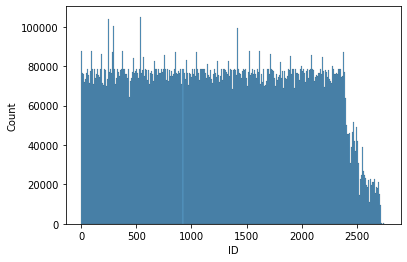

In [ ]:
import seaborn as sb

sb.histplot(data, x="ID")

Este formato comienza por la columna *SAMPLETIME*. Nuestras instancias representan medidas de los contadores en un año aproximadamente, en varias horas dentro de cada día. Procedemos a agregar el consumo por *ID* y por *SAMPLETIME*, para conseguir, por cada *ID*, el consumo diario.

In [ ]:
# Aggregate by day
data_by_day = data.groupby(["ID", data["SAMPLETIME"].dt.date]).agg({
    "READ": 'last',
    "DELTA": 'sum'
})
data_by_day

READ  DELTA
ID   SAMPLETIME                 
0    2019-02-01  331953.0  243.0
     2019-02-02  332189.0  236.0
     2019-02-03  332524.0  335.0
     2019-02-04  332776.0  252.0
     2019-02-05  332996.0  220.0
...                   ...    ...
2748 2019-08-03  406953.0  313.0
     2019-09-14  422515.0    8.0
2749 2019-08-06  156799.0    0.0
     2019-10-11  164507.0    2.0
2756 2019-04-06  349770.0   12.0

[890837 rows x 2 columns]

Una vez hecho esto, realizamos una tabla, con *SAMPLETIME* como identificador de las filas, e *ID* de contador como nombres de las columnas. El contenido de esta tabla será el valor *DELTA*.

Hemos elegido trabajar sólo con el valor *DELTA*, pues *DELTA* y *READ* no son variables independientes. 

In [ ]:
data_by_day_pivot = data_by_day.pivot_table(index="SAMPLETIME", columns=["ID"], values=["DELTA"], fill_value=0)

In [ ]:
data_by_day_pivot.head()

DELTA                                                        \
ID           0     1    2      3       4       5       6      7    8      
SAMPLETIME                                                                
2019-02-01  243.0   8.0  0.0  492.0  247.56  442.98    80.0   45.0  4.0   
2019-02-02  236.0  47.0  0.0  381.0  235.68     0.0    11.0   36.0  0.0   
2019-02-03  335.0   6.0  0.0  313.0  254.35     0.0    69.0  426.0  0.0   
2019-02-04  252.0  12.0  0.0  362.0   412.0     0.0  269.98  433.0  7.0   
2019-02-05  220.0  44.0  0.0  380.0   269.0     0.0  226.96   63.0  0.0   

                   ...                                                    
ID           9     ... 2739 2742 2743 2744 2745 2746 2747 2748 2749 2756  
SAMPLETIME         ...                                                    
2019-02-01  109.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-02-02  305.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-02-03  205.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-02-04  287.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-02-05  150.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 2747 columns]

In [ ]:
data_by_day_pivot.columns

MultiIndex([('DELTA',    0),
            ('DELTA',    1),
            ('DELTA',    2),
            ('DELTA',    3),
            ('DELTA',    4),
            ('DELTA',    5),
            ('DELTA',    6),
            ('DELTA',    7),
            ('DELTA',    8),
            ('DELTA',    9),
            ...
            ('DELTA', 2739),
            ('DELTA', 2742),
            ('DELTA', 2743),
            ('DELTA', 2744),
            ('DELTA', 2745),
            ('DELTA', 2746),
            ('DELTA', 2747),
            ('DELTA', 2748),
            ('DELTA', 2749),
            ('DELTA', 2756)],
           names=[None, 'ID'], length=2747)

In [ ]:
data_by_day_pivot.columns = [str(s2) for (s1,s2) in data_by_day_pivot.columns.tolist()]
data_by_day_pivot.reset_index(inplace=True)
data_by_day_pivot.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,SAMPLETIME,0,1,2,3,4,5,6,7,8,...,2739,2742,2743,2744,2745,2746,2747,2748,2749,2756
0,2019-02-01,243.0,8.0,0.0,492.0,247.56,442.98,80.0,45.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-02-02,236.0,47.0,0.0,381.0,235.68,0.0,11.0,36.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-02-03,335.0,6.0,0.0,313.0,254.35,0.0,69.0,426.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-02-04,252.0,12.0,0.0,362.0,412.0,0.0,269.98,433.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-02-05,220.0,44.0,0.0,380.0,269.0,0.0,226.96,63.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_by_day_pivot.to_csv(f"{ROOT_PATH}/Modelar_UH2022_preprocess_pivot.txt", index=False)

In [ ]:
!head $ROOT_PATH/Modelar_UH2022_preprocess_pivot.txt

SAMPLETIME,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274

Vamos a comenzar importando los datos preprocesados.

In [ ]:
import pandas as pd

# Import dataset
data = pd.read_csv(f"{ROOT_PATH}/Modelar_UH2022_preprocess_pivot.txt",
                   sep=",",
                   dtype={
                       "SAMPLETIME": 'str',
                   })
data["SAMPLETIME"] = pd.to_datetime(data["SAMPLETIME"], format="%Y-%m-%d %H:%M")

In [ ]:
data.head()

,SAMPLETIME,0,1,2,3,4,5,6,7,8,...,2739,2742,2743,2744,2745,2746,2747,2748,2749,2756
0,2019-02-01,243.0,8.0,0.0,492.0,247.56,442.98,80.00,45.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-02-02,236.0,47.0,0.0,381.0,235.68,0.00,11.00,36.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-02-03,335.0,6.0,0.0,313.0,254.35,0.00,69.00,426.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-02-04,252.0,12.0,0.0,362.0,412.00,0.00,269.98,433.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-02-05,220.0,44.0,0.0,380.0,269.00,0.00,226.96,63.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.tail()

,SAMPLETIME,0,1,2,3,4,5,6,7,8,...,2739,2742,2743,2744,2745,2746,2747,2748,2749,2756
360,2020-01-27,213.0,4.00,39.0,289.0,263.60,0.0,204.0,118.0,887.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
361,2020-01-28,232.0,1.00,40.0,380.0,303.40,0.0,169.0,135.0,12.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362,2020-01-29,403.0,1.98,45.0,404.0,421.00,0.0,195.0,77.0,472.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363,2020-01-30,425.0,10.00,27.0,339.0,420.00,0.0,152.0,39.0,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
364,2020-01-31,255.0,32.95,59.0,391.0,253.98,0.0,210.0,38.0,332.14,...,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora, tranformamos nuestro DataFrame a una matrix de Numpy

In [ ]:
data_np = data.drop("SAMPLETIME", axis=1).to_numpy()
data_np

array([[243.  ,   8.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [236.  ,  47.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [335.  ,   6.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       ...,
       [403.  ,   1.98,  45.  , ...,   0.  ,   0.  ,   0.  ],
       [425.  ,  10.  ,  27.  , ...,   0.  ,   0.  ,   0.  ],
       [255.  ,  32.95,  59.  , ...,   0.  ,   0.  ,   0.  ]])

Lo siguiente que haremos es escalar nuestros datos

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data_np_scaled = scaler.fit_transform(data_np)

Necesitamos dar formato a nuestros datos para entrenar una red recurrente. Para ello:

*   X contendrá los valores de delta para cada contador, `loopback`días antes.
*   y contendrá los valores de delta para cada contador, los siete días posteriores, n el valor de delta para dicha semana completa, y la siguiente semana.



In [ ]:
import numpy as np

def split_sequences(sequences, lookback):
    X, y = list(), list()

    for i in range(len(sequences)):
        end_idx = i + lookback

        out_first_week_idx = end_idx + 7
        out_second_week_idx = end_idx + 14

        if out_second_week_idx > len(sequences):
            break

        seq_x = sequences[i:end_idx, :]
        X.append(seq_x)

        first_week = sequences[end_idx:out_first_week_idx, :]
        second_week = sequences[end_idx:out_second_week_idx, :]

        first_week_sum = np.sum(first_week, axis=0)
        second_week_sum = np.sum(second_week, axis=0)
        
        seq_y = np.vstack([first_week, first_week_sum, second_week_sum])

        y.append(seq_y)
          
    return np.array(X), np.array(y)

In [ ]:
lookback = 3
X, y = split_sequences(data_np_scaled, lookback)

In [ ]:
for i in range(5):
	print(X[i], y[i])

[[0.39836066 0.02787456 0.         ... 0.         0.         0.        ]
 [0.38688525 0.16376307 0.         ... 0.         0.         0.        ]
 [0.54918033 0.02090592 0.         ... 0.         0.         0.        ]] [[0.41311475 0.04181185 0.         ... 0.         0.         0.        ]
 [0.36065574 0.1533101  0.         ... 0.         0.         0.        ]
 [0.45245902 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.51639344 0.21602787 0.         ... 0.         0.         0.        ]
 [2.94262295 0.75627178 0.         ... 0.         0.         0.        ]
 [6.30327869 1.111777   0.12068966 ... 0.         0.         0.        ]]
[[0.38688525 0.16376307 0.         ... 0.         0.         0.        ]
 [0.54918033 0.02090592 0.         ... 0.         0.         0.        ]
 [0.41311475 0.04181185 0.         ... 0.         0.         0.        ]] [[0.36065574 0.1533101  0.         ... 0.         0.         0.        ]
 [0.45245902 0.         0.         ... 0.  

In [ ]:
X.shape

(349, 3, 2747)

In [ ]:
y.shape

(349, 9, 2747)

Vamos a comenzar entrenando un modelo simple de red LSTM.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

n_features = X.shape[2]
n_steps = y.shape[1]
n_series = y.shape[2]

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(lookback, n_features)))
model.add(RepeatVector(n_steps))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_series, activation='relu')))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=400)

Epoch 1/400
11/11 [==============================] - 5s 56ms/step - loss: 1.7022
Epoch 2/400
11/11 [==============================] - 1s 57ms/step - loss: 1.0595
Epoch 3/400
11/11 [==============================] - 1s 54ms/step - loss: 0.7725
Epoch 4/400
11/11 [==============================] - 1s 54ms/step - loss: 0.6081
Epoch 5/400
11/11 [==============================] - 1s 58ms/step - loss: 0.5062
Epoch 6/400
11/11 [==============================] - 1s 56ms/step - loss: 0.4676
Epoch 7/400
11/11 [==============================] - 1s 56ms/step - loss: 0.4398
Epoch 8/400
11/11 [==============================] - 1s 53ms/step - loss: 0.4117
Epoch 9/400
11/11 [==============================] - 1s 55ms/step - loss: 0.3676
Epoch 10/400
11/11 [==============================] - 1s 55ms/step - loss: 0.3196
Epoch 11/400
11/11 [==============================] - 1s 53ms/step - loss: 0.2911
Epoch 12/400
11/11 [==============================] - 1s 53ms/step - loss: 0.2764
Epoch 13/400
11/11 [=====

In [ ]:
yPred = model.predict(X)

Vamos a visualizar los valores reales de *DELTA* frente a los valores estimados por nuestra red. Como se puede ver, la red consigue dar con la forma del consumo, aunque la variabilidad de los valores estimados es menor que la de los reales.

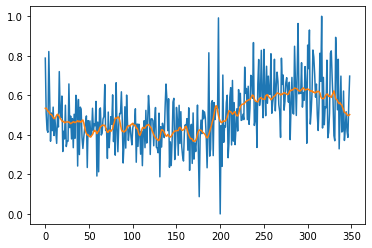

In [ ]:
import matplotlib.pyplot as plt

counter = 0
day = 4

plt.plot(y[:, counter, day])
plt.plot(yPred[:, counter, day])
plt.show()

In [ ]:
yPred.shape

(349, 9, 2747)

In [ ]:
yPred[0]

array([[0.4270809 , 0.05270596, 0.0183109 , ..., 0.        , 0.        ,
        0.        ],
       [0.42759502, 0.06829808, 0.01579954, ..., 0.        , 0.        ,
        0.        ],
       [0.41112015, 0.07621522, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.4390845 , 0.07006988, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.8882945 , 0.59995675, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [6.347964  , 1.0437386 , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

Vamos a rotar los resultados, de forma que tengan el formato requerido por el problema:

Constará de 2.747 filas con las siguientes columnas:
* Dia_1: Predicción para el primer día
* Dia_2: Predicción para el segundo día
* Dia_3: Predicción para el tercer día
* Dia_4: Predicción para el cuarto día
* Dia_5: Predicción para el quinto día
* Dia_6: Predicción para el sexto día
* Dia_7: Predicción para el séptimo día
* Semana_1: Predicción para la primera semana
* Semana_2: Predicción para la segunda semana

In [ ]:
yPredRot = np.rot90(yPred, 1, (1,2))
yPredRot = np.flip(yPredRot, 1)

In [ ]:
yPredRot.shape

(349, 2747, 9)

El problema nos pide estimar los valores de *DELTA* para las dos primeras semanas de febrero de 2020. Para ellos vamos a predecir estos valores a partir del último día de los datos proporcionados, dicho día es el 31 de enero.

In [ ]:
lastDay = X[-1]
lastDay.shape

(3, 2747)

In [ ]:
yEntrega = model.predict(np.array([lastDay,]))

In [ ]:
def GetSubmissionResults(model, X):
    lastDay = X[-1]
    yPred = model.predict(np.array([lastDay,]))

    yOrig = scaler.inverse_transform(yPred[0])

    yOrigRot = np.rot90(yOrig)
    yOrigRot = np.flip(yOrigRot, 0)

    return yOrigRot

In [ ]:
GetSubmissionResults(model, X)

Para buscar los mejores hiperparámetros aplicables a nuestra red, hemos realizado un grid-search, donde probamos diferentes combinaciones de hiperparámetros:

* Loopback
* Número de capas LSTM
* Número de capas densas
* Utilización de Dropout
* Función de activación
* Learning rate

In [ ]:
from keras.metrics import TruePositives
from pickle import TRUE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop, Adam

def create_model(lookback=0,
                 n_features=0,
                 n_steps=0,
                 n_series=0,
                 lstm_layers=(),
                 dense_layers=(),
                 use_dropout=False,
                 activation_func="sigmoid",
                 optimizer=Adam,
                 lr=0.01):
    assert lookback!=0 or n_features!=0 or n_steps!=0 or n_series!=0
    
    # Initialize the constructor
    model = Sequential()
        
    # LSTM Layers
    for i in range(len(lstm_layers)):  
        return_sequences = (i < len(lstm_layers)-1) 
             
        if i == 0:
            model.add(LSTM(lstm_layers[i],
                           activation=activation_func,
                           input_shape=(lookback, n_features),
                           return_sequences=return_sequences))
        else:
            model.add(LSTM(units=lstm_layers[i],
                           activation=activation_func,
                           return_sequences=return_sequences))

        if use_dropout:
            model.add(Dropout(0.2))

    model.add(RepeatVector(n_steps))
                    
    # Dense layers
    for i in range(len(dense_layers)):        
        model.add(TimeDistributed(Dense(dense_layers[i],
                                        activation=activation_func)))
        
        if use_dropout:
            model.add(Dropout(0.2))

    # Output layer
    model.add(TimeDistributed(Dense(n_series, activation="relu")))

    
    model.compile(optimizer=optimizer(learning_rate=lr), loss="mse")

    return model

In [ ]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
from datetime import datetime
from pathlib import Path

param_grid = dict(
    lookback=[3, 7, 14],
    lstm_layers=[
        (200,),
        (64, 64), (200, 200),
        (400, 200, 100),
        (200,100,50,10)
    ],
    dense_layers=[
        (),
        (64,),
    ],
    activation_func=["relu", "tanh"],
    use_dropout = [True, False],
    optimizer = [Adam],
    lr = [0.01]
)

ts = datetime.now().strftime("%d-%m-%Y-%H:%M:%S")
output_dir = f"{ROOT_PATH}/results/{ts}"
Path(output_dir).mkdir(parents=True, exist_ok=True)

colnames=["lookback", "lstm_layers", "dense_layers", "use_dropout", "activation_func", "optimizer", "mse"]
results_grid = []

combinations = list(ParameterGrid(param_grid))
print(f"Testing {len(combinations)} combinations")

for i, params in enumerate(combinations):
    X, y = split_sequences(data_np_scaled, params["lookback"])

    lookback = X.shape[1]
    n_features = X.shape[2]
    n_steps = y.shape[1]
    n_series = y.shape[2]
    lstm_layers = params["lstm_layers"]
    dense_layers = params["dense_layers"]
    use_dropout = params["use_dropout"]
    activation_func = params["activation_func"]
    optimizer = params["optimizer"]

    print(f"Exec {i}/{len(combinations)}:\n{params}")

    model = create_model(lookback=lookback,
                         n_features=n_features,
                         n_steps=n_steps,
                         n_series=n_series,
                         lstm_layers=lstm_layers,
                         dense_layers=dense_layers,
                         use_dropout=use_dropout,
                         activation_func=activation_func,
                         optimizer=optimizer)
    
    model.fit(X, y, epochs=200, verbose=0)
    mse = model.evaluate(X, y, batch_size=1)
    print(f"Exec {i}/{len(combinations)} MSE: {mse}") 

    results_grid.append([lookback, lstm_layers, dense_layers, use_dropout, activation_func, optimizer, mse])
    results_interm_df = pd.DataFrame(results_grid, columns=colnames)
    results_interm_df.to_csv(f"{output_dir}/results_{i}_of_{len(combinations)}.txt")
     
results_df = pd.DataFrame(results_grid, columns=colnames)
results_df.to_csv(f"{output_dir}/results_all.txt")

Testing 120 combinations
Exec 0/120:
{'activation_func': 'relu', 'dense_layers': (), 'lookback': 3, 'lr': 0.01, 'lstm_layers': (200,), 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'use_dropout': True}
349/349 [==============================] - 1s 3ms/step - loss: 1.5366
Exec 0/120 MSE: 1.536622166633606
Exec 1/120:
{'activation_func': 'relu', 'dense_layers': (), 'lookback': 3, 'lr': 0.01, 'lstm_layers': (200,), 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'use_dropout': False}
349/349 [==============================] - 1s 3ms/step - loss: 1.8804
Exec 1/120 MSE: 1.8804408311843872
Exec 2/120:
{'activation_func': 'relu', 'dense_layers': (), 'lookback': 3, 'lr': 0.01, 'lstm_layers': (64, 64), 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'use_dropout': True}
349/349 [==============================] - 2s 4ms/step - loss: 1.3979
Exec 2/120 MSE: 1.3978854417800903
Exec 3/120:
{'activation_func': 'relu', 'dense_layers': (), 'lookback': 3, 'lr': 0.01, 'lstm_layers': (64,

Importamos el dataframe con los resultados del grid-search

In [ ]:
import pandas as pd
results_df = pd.read_csv(f"{ROOT_PATH}/results/19-03-2022-21:37:08/results_all.txt")
results_df

,Unnamed: 0,lookback,lstm_layers,dense_layers,use_dropout,activation_func,optimizer,mse
0,0,3,"(200,)",(),True,relu,<class 'keras.optimizer_v2.adam.Adam'>,1.536622
1,1,3,"(200,)",(),False,relu,<class 'keras.optimizer_v2.adam.Adam'>,1.880441
2,2,3,"(64, 64)",(),True,relu,<class 'keras.optimizer_v2.adam.Adam'>,1.397885
3,3,3,"(64, 64)",(),False,relu,<class 'keras.optimizer_v2.adam.Adam'>,1.549279
4,4,3,"(200, 200)",(),True,relu,<class 'keras.optimizer_v2.adam.Adam'>,1.439455
...,...,...,...,...,...,...,...,...
115,115,14,"(200, 200)","(64,)",False,tanh,<class 'keras.optimizer_v2.adam.Adam'>,1.555327
116,116,14,"(400, 200, 100)","(64,)",True,tanh,<class 'keras.optimizer_v2.adam.Adam'>,1.486074
117,117,14,"(400, 200, 100)","(64,)",False,tanh,<class 'keras.optimizer_v2.adam.Adam'>,1.537145
118,118,14,"(200, 100, 50, 10)","(64,)",True,tanh,<class 'keras.optimizer_v2.adam.Adam'>,1.470775


Y ordenamos por el valor, ascendente, de MSE.

In [ ]:
results_df.sort_values("mse")

,Unnamed: 0,lookback,lstm_layers,dense_layers,use_dropout,activation_func,optimizer,mse
2,2,3,"(64, 64)",(),True,relu,<class 'keras.optimizer_v2.adam.Adam'>,1.397885
32,32,3,"(64, 64)","(64,)",True,relu,<class 'keras.optimizer_v2.adam.Adam'>,1.406834
92,92,3,"(64, 64)","(64,)",True,tanh,<class 'keras.optimizer_v2.adam.Adam'>,1.413037
30,30,3,"(200,)","(64,)",True,relu,<class 'keras.optimizer_v2.adam.Adam'>,1.416481
66,66,3,"(400, 200, 100)",(),True,tanh,<class 'keras.optimizer_v2.adam.Adam'>,1.420354
...,...,...,...,...,...,...,...,...
53,53,14,"(64, 64)","(64,)",False,relu,<class 'keras.optimizer_v2.adam.Adam'>,2.096833
54,54,14,"(200, 200)","(64,)",True,relu,<class 'keras.optimizer_v2.adam.Adam'>,2.096833
55,55,14,"(200, 200)","(64,)",False,relu,<class 'keras.optimizer_v2.adam.Adam'>,2.096833
21,21,14,"(200,)",(),False,relu,<class 'keras.optimizer_v2.adam.Adam'>,2.096833


Como podemos comprobar, la red que mejores resultados ha obtenido tiene los siguientes hiperparámetros:

* Loopback = 3
* 2 capas LSTM con 64 neuronas cada una
* Ninguna capa densa
* Utiliza dropout
* Función de activación relu
* Optmizador Adam
* Learning rate = 0.01

En un primer momento, hemos vuelto a entrenar esta red neuronal, pero nos ha parecido conveniente probar a realizar otro modelo con una tercera capa LSTM de 64 neuronas, y ha mejorado el resultado obtenido anteriormente. También hemos aumentado el número de épocas.

In [ ]:
X, y = split_sequences(data_np_scaled, 3)

lookback = X.shape[1]
n_features = X.shape[2]
n_steps = y.shape[1]
n_series = y.shape[2]

final_model = create_model(lookback=lookback,
                           n_features=n_features,
                           n_steps=n_steps,
                           n_series=n_series,
                           lstm_layers=(64, 64, 64),
                           dense_layers=(),
                           use_dropout=True,
                           activation_func="relu",
                           optimizer=Adam)
    
final_model.fit(X, y, epochs=400, verbose=1)

Epoch 1/400
11/11 [==============================] - 5s 36ms/step - loss: 2.1016
Epoch 2/400
11/11 [==============================] - 0s 36ms/step - loss: 1.5843
Epoch 3/400
11/11 [==============================] - 0s 35ms/step - loss: 1.5239
Epoch 4/400
11/11 [==============================] - 0s 36ms/step - loss: 1.4999
Epoch 5/400
11/11 [==============================] - 0s 34ms/step - loss: 1.4961
Epoch 6/400
11/11 [==============================] - 0s 36ms/step - loss: 1.4899
Epoch 7/400
11/11 [==============================] - 0s 34ms/step - loss: 1.4863
Epoch 8/400
11/11 [==============================] - 0s 34ms/step - loss: 1.4795
Epoch 9/400
11/11 [==============================] - 0s 35ms/step - loss: 1.4768
Epoch 10/400
11/11 [==============================] - 0s 34ms/step - loss: 1.4706
Epoch 11/400
11/11 [==============================] - 0s 34ms/step - loss: 1.4655
Epoch 12/400
11/11 [==============================] - 0s 35ms/step - loss: 1.4646
Epoch 13/400
11/11 [=====

In [ ]:
mse = final_model.evaluate(X, y, batch_size=1)
print(f"MSE: {mse}")

349/349 [==============================] - 2s 3ms/step - loss: 1.3958
MSE: 1.3958357572555542


Con este modelo, vamos a obtener la predicción de consumo de las dos primeras semanas de febrero:

In [ ]:
ySubmission = GetSubmissionResults(final_model, X)

In [ ]:
ySubmission

array([[893.4806 , 893.4806 , 893.4806 , ..., 893.4806 , 893.4806 ,
        893.4806 ],
       [ 40.84889,  40.84889,  40.84889, ...,  40.84889,  40.84889,
         40.84889],
       [100.7303 , 100.7303 , 100.7303 , ..., 100.7303 , 100.7303 ,
        100.7303 ],
       ...,
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ]], dtype=float32)

In [ ]:
ySubmission.shape

(2747, 9)

In [ ]:
data.columns

2748

Por último, añadimos el nombre de las columnas, y el *ID* de los contadores.

In [ ]:
ySubmissionDF = pd.DataFrame(ySubmission, columns=["Dia_1", "Dia_2", "Dia_3", "Dia_4", "Dia_5", "Dia_6", "Dia_7", "Semana_1", "Semana_2"])
ySubmissionDF = ySubmissionDF.set_index(data.columns[1:])
ySubmissionDF

,Dia_1,Dia_2,Dia_3,Dia_4,Dia_5,Dia_6,Dia_7,Semana_1,Semana_2
0,893.480591,893.480591,893.480591,893.480591,893.480591,893.480591,893.480591,893.480591,893.480591
1,40.848888,40.848888,40.848888,40.848888,40.848888,40.848888,40.848888,40.848888,40.848888
2,100.730301,100.730301,100.730301,100.730301,100.730301,100.730301,100.730301,100.730301,100.730301
3,1007.130127,1007.130127,1007.130127,1007.130127,1007.130127,1007.130127,1007.130127,1007.130127,1007.130127
4,930.518005,930.518005,930.518005,930.518005,930.518005,930.518005,930.518005,930.518005,930.518005
...,...,...,...,...,...,...,...,...,...
2746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2748,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Y lo guardamos en el archivo final con los resultados de nuestro experimento.

In [ ]:
from datetime import datetime
from pathlib import Path

ts = datetime.now().strftime("%d-%m-%Y-%H:%M:%S")

output_dir = Path(f"{ROOT_PATH}/submissions/{ts}")
output_dir.mkdir(parents=True, exist_ok=True)

ySubmissionDF.to_csv(f"{output_dir}/Lando_UH2022.txt", sep="|", header=False)